# TD 4 : Le modèle Leaky-Integrate-and-Fire, statistique de trains de spike
---

# Première partie : Devoir 3  

Dans ces exercises, on va enfin faire une vraie "simulation" d'activité neuronale avec le modèle de neurone vraisemblablement ***le plus simple et le plus puissant*** à la fois. 

***Simple*** car décrit par une équation assez simple qu'on peut facilement intégrer numériquement, et même résoudre analytiquement comme nous l'avons vu pour des courants simples. Simple aussi parce que dans ce modèle, un spike n'est finalement rien d'autre que le franchissement d'un seuil : simple sur le plan conceptuel. 

***Puissant*** enfin, car il se prète du coup parfaitement à l'étude mathématique même dans des situations plus complèxes (par ex. quand on considère des neurones qui reçoivent des courants fluctuants, plus réaliste pour les neurones dans le cortex), et parce qu'on peut très bien combiner beaucoup de tels neurones pour simuler des réseaux.

Essentiellement, le devoir reprend les points que nous n'avons pas pu finir dans le cours ; j'espère qu'avec plus de temps, d'une semaine à l'autre, il vous permettra d'assimiler d'avantage les concepts abordés jusqu'ici : intégration numérique d'équations différentielles, la modélisation d'activité neuronale par une description simplifiée (tenant compte uniquement des aspects les plus saillants), et enfin la statistique de trains de spikes. 

## 1. Intégration numérique du modèle Integrate-and-Fire avec décharge

La semaine précédente, nous avons utilisé la méthode d'Euler pour résoudre des équations différentielles. Nous pouvons utiliser cette même technique pour résoudre la dynamique sous-seuil d'un neurone LIF (Leaky Integrate-and-Fire), en rajoutant un mécanisme de détection de spike et de reset.

Pour rappel, la dynamique ***sous-seuil*** (!) d'un neurone LIF est donnée par l'équation

$$\frac{dV}{dt} = \frac{1}{\tau}(E_L - V + RI)$$

Chaque fois que le potentiel $V$ franchit un seuil $V_{\rm seuil}$ par le bas, le modèle stipule qu'un PA est émis, et par la suite le potentiel est remis à sa valeur de "reset", $V\to V_{\rm reset}$.

Comme dans le TD3, nous considérons ici pour simplicité que $E_L=0$ mV, ainsi que les paramètres suivants : $\tau=20$ ms et $R=1$ MOhm pour la dynamique sous-seuil, et $V_{\rm seuil}=20$ mV avec $V_{\rm reset}=0$ mV pour le mécanisme de décharge. 

**Indice 1 :** Nous avions vu dans le premier TD comment conditionner l'éxecution d'une partie du code sur l'évaluation d'une expression qui peut être soit vraie, soit fausse : le mot-clé c'est `if my_condition:` et puis le code conditionné dans un nouveau bloc. Ici, `my_condition` peut être une expression, voir l'exemple ci-dessous.

**Indice 2 :** Créez une liste `spiketimes = []` à laquelle vous rajoutez le temps pour lequel vous enregistrez un franchissement du seuil. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Example of if-block:

a = 3.
threshold = 2.

if a > threshold:
    print('a is above the threshold')
    # here could be more code, as 
    # long as it is intended relative
    # to the if
else:
    print('a is below the threshold')

a is above the threshold


In [2]:
# SIMULATION OF A LIF NEURON
# --------------------------

Vreset = 0.
Vseuil = 20. # mV
tau = 20. # ms
R = 5. # MOhm

# Definition of the dynamics
# (function returning dV/dt)
def dVdt(v, t, I):
    return (R*I-v)/tau


# Discretization of time
T = 500. # ms
dt = 0.1 # ms
t = np.arange(0,T,dt)
nt = len(t)

V = np.zeros(nt)
V[0] = Vreset

# Iterative integration of 
# the subthreshold dynamics,
# COMBINED WITH threshold
# crossing detection!

I = 4.5 # nA

spiketimes = []

for i in range(nt-1):
    # Euler below threshold
    V[i+1] = V[i] + dt*dVdt(V[i], t[i], I)
    # spike detection
    if V[i+1] > Vseuil:
        spiketimes.append(t[i+1])
        V[i+1] = Vreset


Plottez le potentiel de membrane du neurone LIF sur 500 ms, et choisissez un courant pour lequel le neurone décharge à environ 20 Hz (entre 10 Hz et 30 Hz disons). Combien de PA/spikes est-ce que vous avez enregistrés sur la durée de votre simulation ? Quel est le taux de décharge que vous en déduisez ? 

11 spikes occured during 500.0 ms
Taux de décharge : 0.022 kHz
Taux de décharge : 22.0 Hz


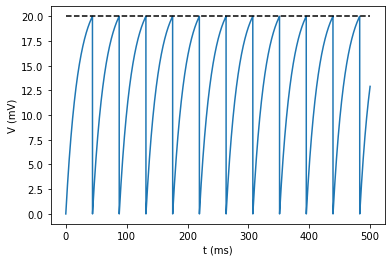

In [3]:
fig, ax = plt.subplots()
ax.plot(t, V)
ax.plot([0,T], [Vseuil, Vseuil], linestyle='--', color='k')
ax.set_xlabel('t (ms)')
ax.set_ylabel('V (mV)')

nspikes = len(spiketimes)
print(nspikes, 'spikes occured during', T, 'ms')
print('Taux de décharge :', nspikes/T, 'kHz')
print('Taux de décharge :', nspikes/(T/1000), 'Hz')

Comparez avec le taux de décharge prédit analytiquement.

In [4]:
def f_I_curve(I):
    T_in_ms = -tau*np.log(1-Vseuil/(R*I))
    T_in_s = T_in_ms/1000
    f_in_Hz = 1/T_in_s
    return f_in_Hz

print('Predicted:', f_I_curve(I), 'Hz; Measured:', nspikes/(T/1000), 'Hz.')

Predicted: 22.75598066567094 Hz; Measured: 22.0 Hz.


## 2. LIF avec courant non-constant

Jusqu'ici, votre première simulation d'un LIF ne va pas au-délà ce qu'on peut calculer analytiquement : le temps entre deux spike consécutifs est toujours le même, l'activité est parfaitement régulière et devrait suivre exactement ce que la théorie prédit. C'est parce que nous avons choisi un courant qui est constant dans le temps, $I=const.$

Dans des simulations de réseau, ou pour des neurones plus réalistes, ce n'est pas le cas, le courant peut lui-même dépendre du temps. On va étudier ici le cas d'un neurone LIF qui est poussé à la décharge par un courant qui est modulé par un sinus, 

$$ I(t) = I_0 + \Delta I sin(2\pi f_{\rm mod} t)$$

Pour ce courant, choisissons $I_0=4.5$ nA (c'est-à-dire juste `4.5` dans les unités de notre modèle, 4.5 nA * 5 MOhm = 22.5 mV), ce qui est un courant moyen au-dessus du seuil, et $\Delta I=1$ nA. 

Pour la fréquence de modulation $f_{\rm mod}$, considerez les trois cas $f_{\rm mod}=2$ Hz, $f_{\rm mod}=20$ Hz, et $f_{\rm mod}=200$ Hz. Attention : 1 Hz = 1/s. Pour calculer le produit $f_{\rm mod} t$, il faut d'abord exprimer la fréquence en kHz, c'est-à-dire la diviser par 1000. (Autrement dit, quand nous calculons le produit de deux quantités avec unités, il faut tenir compte de celles-ci :
$ x\,{\rm Hz} \times y \, {\rm msec} =  x\,{\rm sec}^{-1} \times y \, {\rm msec} = xy\,{\rm sec}^{-1}\,10^{-3}{\rm sec} = 10^{-3} xy$)

**Indice :** La dynamique sous-seuil est toujours donnée par l'équation 

$$\frac{dV}{dt} = \frac{1}{\tau}[E_L - V + RI(t)],$$

sauf que $I$ dépend désormais explicitement du temps !

Calculez $V(t)$ sur une durée de 500 ms et enregistrez les spikes pour les trois différentes valeurs de $\omega$. Plottez $V(t)$ et calculez les taux de décharge respectifs. Qu'est-ce que vous observez ?

In [5]:
# SIMULATION OF A LIF NEURON
# --------------------------

Vreset = 0.
Vseuil = 20. # mV
tau = 20. # ms
R = 5. # MOhm

# Definition of the dynamics
# (function returning dV/dt)
def dVdt(v, t, I):
    return (R*I-v)/tau


# Discretization of time
T = 500. # ms
dt = 0.1 # ms
t = np.arange(0,T,dt)
nt = len(t)


# Iterative integration of 
# the subthreshold dynamics,
# COMBINED WITH threshold
# crossing detection!

I0 = 4.5 # nA
dI = 1.0 # nA

fmods = [2., 20., 200.] # Hz


# create lists to keep potentials & spiketimes
all_V = []
all_spikes = []

for fmod in fmods:

    V = np.zeros(nt)
    V[0] = Vreset
    
    I_of_t = I0 + dI*np.sin(2*np.pi*fmod*t/1000)

    spiketimes = []

    for i in range(nt-1):
        # Euler below threshold
        V[i+1] = V[i] + dt*dVdt(V[i], t[i], I_of_t[i])
        # spike detection
        if V[i+1] > Vseuil:
            spiketimes.append(t[i+1])
            V[i+1] = Vreset

    # append result for one modulation freq. to list
    all_V.append(V)
    all_spikes.append(spiketimes)

Text(0, 0.5, 'V (mV)')

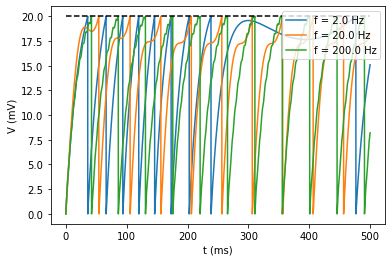

In [6]:
# plot potentials
fig, ax = plt.subplots()
for i in range(len(fmods)):
    ax.plot(t, all_V[i], label='f = %.1f Hz'%fmods[i])
ax.plot([0,T], [Vseuil, Vseuil], linestyle='--', color='k')
ax.legend(loc='upper right')
ax.set_xlabel('t (ms)')
ax.set_ylabel('V (mV)')

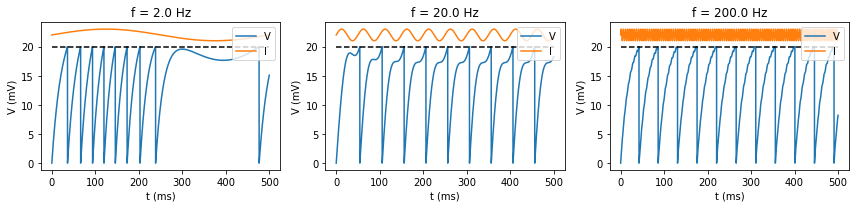

In [7]:
# REMARQUE : Pour une meilleure lisibilité,
# nous pouvons également créer des 'subplots'
# dans un image. Je vous montre ici comment 
# ça marche, mais bien sûr ce n'est pas nécessaire
# de faire comme ça. En passant vous verrez 
# également comment spécifier un titre pour un 
# plot.

fig, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(len(fmods)):
    ax[i].plot(t, all_V[i], label='V')
    ax[i].plot(t, 22 + np.sin(2*np.pi*fmods[i]*t/1000), label='I')
    ax[i].set_title('f = %.1f Hz'%fmods[i])
    ax[i].plot([0,T], [Vseuil, Vseuil], linestyle='--', color='k')
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('t (ms)')
    ax[i].set_ylabel('V (mV)')
plt.tight_layout()

In [8]:
for i in range(len(fmods)):
    nspikes = len(all_spikes[i])
    print('Taux de décharge @ f = %.1f Hz : r = %.1f Hz'%(fmods[i], nspikes/(T/1000)))
    


Taux de décharge @ f = 2.0 Hz : r = 18.0 Hz
Taux de décharge @ f = 20.0 Hz : r = 18.0 Hz
Taux de décharge @ f = 200.0 Hz : r = 22.0 Hz


On observe que la modulation du courant entraîne une modulation de la décharge : À basse fréquence, lorsque le courant est suffisamment longtemps sous le seuil de décharge (le courant nécessaire pour que le neurone décharge, $I_{\rm crit}=V_{\rm seuil}/R - E_L$), le neurone arrête de décharger ; lorsque le courant est élévé, les PA sont plus rapprochés que pour un courant constant. A des fréquences intermédiares, le décours temporel du potentiel est modifié mais la décharge apparaît d'avantage régulier. A haute fréquence, la décharge n'est pas modifié, et la modulation du courant est à peine perceptible comme une petite fluctuation du potentiel autour de la valeur en absence de modulation. 

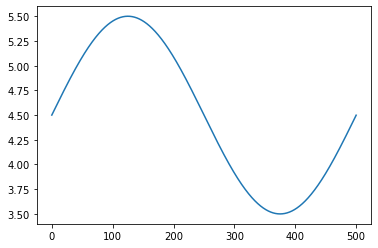

In [9]:
# Lors du TD nous avons 'plotté' le courant en fonction
# du temps pour vérifier que nous nous sommes pas trompés
# pour les unités.

I0 = 4.5 # nA
dI = 1.0 # nA

fmod = 2. # Hz

I_of_t = I0 + dI*np.sin(2*np.pi*fmod*t/1000)

fig, ax = plt.subplots()
ax.plot(t, I_of_t)

# Deuxième partie : Analyse de trains de spike

## 1. Activité irrégulière des neurones corticaux

Dans le cortex, le timing des potentiels d'action successifs est très irrégulier. Le coefficient de variation des intervalles inter-spike est proche de 1, similaire à un processus de Poisson. C'est un processus stochastique pour lequel la probabilité qu'un évenement se produit à un moment donné (ou plutôt dans un petit interval $\Delta t$) est constant. Pour un processus de Poisson, la probabilité $p$ pour que le temps d'attente jusqu'au spike suivant est $T$ est donnée par 
$$p(T) = f {\rm e}^{-f T}$$
Ici, $T$ est l'intervalle interspike, et $f$ est le taux de décharge. 

Ainsi, la densité de l'intervalle interspike pour un train de spike de Poisson homogène est une fonction exponentielle. Les intervalles d'interspike les plus probables sont courts et les intervalles longs ont une probabilité qui diminue de façon exponentielle en fonction de leur durée. Les histogrammes d'intervalles interspike peuvent être extraits des potentiels d'action en calculant la différence de temps entre tous les spikes successifs.  

Dans cette approximation la plus simple, le temps du spike suivant n'est pas du tout correlé avec le temps du spike précédant. Evidemment, cela n'est pas vrai dès lors qu'il y a un temps refractaire, comme c'est biologiquement impossible qu'un neuron décharge par ex. deux fois d'affilé dans l'espace de moins d'une ms.

## 1.1 Génération d'un train de spike Poissonien

Nous allons générer un train de spikes de Poisson avec un taux de décharge moyen de $f = 10$ Hz. Dans tous les cas, pour réproduire le côté stochastique (c'est-à-dire aléatoire), nous devrons utiliser la fonctionnalité de génération de nombres aléatoires contenu dans le module `numpy.random`. Enfin, on peut créer des trains de spike avec des caractéristiques Poissonien de plusieurs façons : 

(1) En utilisant le fait que les ISI suivent une distribution exponentielle ; on tire des ISI aléatoires qui définissent ainsi l'ensemble des temps de spike. 

(2) En utilisant le fait que la probabilité qu'un spike se produise à un petit interval est constant et connue ; dans ce cas, on tire des nombres aléatoires pour déterminer si dans un petit interval il y a un spike ou pas.

In [10]:
#times = [1, 3, 3.4, 8.9, 12.]  # bad to do manually...

# 1) Discretization of time
T = 20000. # ms
dt = 1.0 # ms
t = np.arange(0,T,dt)
nt = len(t)

f = 10e-3 # kHz


# 2) What is the probability to observe a spike in bin of width dt?
p = f*dt
#print(p)

# 3) Create array that represents activity (spike or no spike)

# element-wise ("slow") way
#activity = np.zeros(nt) # 0 if no spike in bin, 1 if spike in bin
#for i in range(nt):
#    if np.random.uniform() < p:
#        activity[i] = 1

# array-based way
activity = 1*(np.random.uniform(size=nt) < p)

print(activity.sum())


# 4) Extract spiketimes

# element-wise ("slow") way
#spiketimes = []
#for i in range(nt):
#    if activity[i]==1:
#        spiketimes.append(t[i])

# array-based way
spiketimes = np.where(activity==1)[0]*dt

print(spiketimes)

206
[  149.   156.   165.   354.   374.   414.   442.   450.   480.   535.
   771.   812.   996.  1168.  1197.  1407.  1486.  1569.  1738.  1939.
  1940.  2014.  2033.  2110.  2357.  2672.  2743.  2748.  2943.  2997.
  3016.  3132.  3145.  3205.  3220.  3533.  3756.  3812.  3875.  3900.
  4075.  4102.  4301.  4415.  4469.  4491.  4510.  4736.  5100.  5405.
  5523.  5564.  5569.  5575.  5730.  5862.  5904.  5905.  5916.  5987.
  6016.  6195.  6218.  6324.  6405.  6428.  6497.  6692.  6853.  6886.
  6903.  6930.  6959.  6989.  7024.  7088.  7109.  7197.  7321.  7471.
  7533.  7591.  7613.  7630.  7679.  7881.  7895.  8082.  8112.  8198.
  8294.  8407.  8441.  8615.  8779.  8810.  8828.  8844.  8916.  8963.
  9104.  9355.  9503.  9683.  9919.  9966. 10074. 10155. 10239. 10369.
 10585. 10618. 10793. 10966. 11008. 11009. 11017. 11119. 11313. 11377.
 11399. 11445. 11472. 11614. 11632. 11708. 11806. 11816. 11949. 12023.
 12162. 12231. 12258. 12272. 12536. 12556. 12926. 13079. 13088. 13157.
 1

## 1.2 Les statistiques d'un train de spike : taux de décharge moyen, CV, distribution des ISI

Calculez la moyenne et l'écart type des intervalles interspike (ISI). Vérifier que le coefficient de variation (CV = écart type/moyenne) est égal à 1. Tracez l'histogramme des ISI. 

In [11]:
# the inter-spike intervals (ISIs) are
# the differences between spiketimes t[i] 
# and t[i+1], i.e., isi[i] = t[i+1]-t[i]

# using np.diff
isis = np.diff(spiketimes)

mean = np.mean(isis)
cv = np.std(isis)/mean

print('CV = ',cv)
print('Average firing rate (based on spike count):', len(spiketimes)/(T/1000), 'Hz')
print('Average firing rate (based on ISIs):', 1000/mean, 'Hz')

CV =  0.8755785750730567
Average firing rate (based on spike count): 10.3 Hz
Average firing rate (based on ISIs): 10.395010395010395 Hz


Text(0, 0.5, '# of occurences')

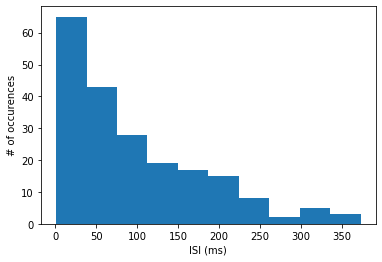

In [12]:
# Distribution of ISIs
fig, ax = plt.subplots()
ax.hist(isis)
ax.set_xlabel('ISI (ms)')
ax.set_ylabel('# of occurences')